In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stat
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import math
import textdistance
import string
import re
from collections import defaultdict

In [2]:
from research.strings import VIOLATIONS, MONTHS

In [3]:
df_canvass = pd.read_csv("data/canvass_records.csv.gz")
df_canvass["critical_found"] = df_canvass[VIOLATIONS].max(axis=1)
print("Read {} canvass records.".format(len(df_canvass)))

Read 50462 canvass records.


In [4]:
df_weather = pd.read_csv("data/historical_weather.csv")
print("Read {} weather records.".format(len(df_weather)))

Read 108 weather records.


In [5]:
weather_dict = defaultdict(lambda: {})
for rec in df_weather.to_dict(orient="records"):
    weather_dict[rec["year"]][rec["month"]] = rec["temperature"]
print("Mapped {} weather records.".format(sum([len(d) for d in weather_dict.values()])))

Mapped 108 weather records.


In [6]:
temps = [weather_dict[d["year"]][d["month"]] for d in df_canvass[["year", "month"]].to_dict(orient="records")]
df_canvass["avg_temp"] = temps
mu = np.mean(temps)
sigma = np.std(temps)
df_canvass["z_temp"] = [(t - mu) / sigma for t in temps]
print("Mean Monthly Avg. Temp. = {0:.1f} F".format(mu))
print("Std. Monthly Avg. Temp. = {0:.1f} F".format(sigma))

Mean Monthly Avg. Temp. = 53.3 F
Std. Monthly Avg. Temp. = 17.9 F


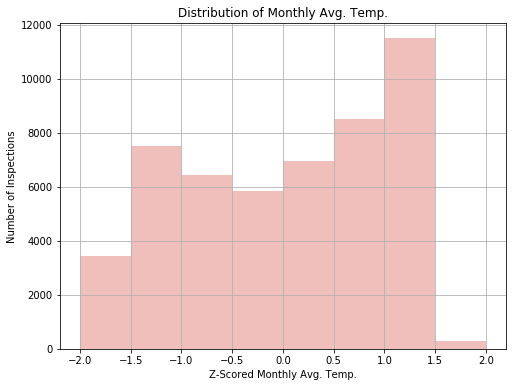

In [7]:
pal = sns.color_palette("hls", 1)
sns.distplot(df_canvass["z_temp"], kde=False, bins=np.arange(-2.0, 2.5, 0.5), color=pal[0])
plt.title("Distribution of Monthly Avg. Temp.")
plt.xlabel("Z-Scored Monthly Avg. Temp.")
plt.ylabel("Number of Inspections")
plt.grid()
plt.gcf().set_size_inches(8, 6)
plt.show()

In [8]:
def clean_name(original, backup, fallback="nullname"):
    name = fallback
    if not pd.isna(original):
        name = original
    elif not pd.isna(backup):
        name = backup
    clean = name.casefold()
    for p in list(string.punctuation):
        clean = clean.replace(p, "")
    clean = clean.replace(" ", "_")
    return clean

In [9]:
name_opts = df_canvass[["aka_name", "dba_name"]].to_dict(orient="records")
df_canvass["clean_name"] = [clean_name(n["aka_name"], n["dba_name"]) for n in name_opts]

In [10]:
name_labels_dict = defaultdict(lambda: [])
rest_names = []
with open("models/names/all_names.txt", "r") as all_names_file:
    rest_names = [re.sub("\.txt$", "", f) for f in all_names_file.read().split()]
    for rest_name in rest_names:
        with open("models/names/" + rest_name + ".txt", "r") as name_file:
            all_names = [re.sub("\.txt$", "", f) for f in name_file.read().split()]
            for name in all_names:
                name_labels_dict[name].append(rest_name)
print("Read {} name clusters.".format(len(rest_names)))
print("Mapped {} unique names.".format(len(name_labels_dict)))

Read 51 name clusters.
Mapped 458 unique names.


In [11]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [12]:
mlb = MultiLabelBinarizer()
all_rest_labels = df_canvass["clean_name"].apply(lambda n: name_labels_dict[n])
all_rest_vecs = mlb.fit_transform(all_rest_labels)

In [13]:
in_top_rests = all_rest_vecs.max(axis=1)
rest_vecs = all_rest_vecs[in_top_rests.astype(bool)]
df_rests = df_canvass[in_top_rests.astype(bool)]
print("Found {} inspections included in name clusters.".format(sum(in_top_rests)))
print("Filtered {} vectors.".format(len(rest_vecs)))
print("Filtered {} rows.".format(len(df_rests)))

Found 8783 inspections included in name clusters.
Filtered 8783 vectors.
Filtered 8783 rows.


In [14]:
xdf = pd.DataFrame(rest_vecs, columns=mlb.classes_)
xdf.insert(loc=0, column="z_temp", value=df_rests["z_temp"].values)
columns = xdf.columns
X = xdf.values
xdf.head()

,z_temp,afc_sushi,als_beef,arbys,argo_tea,au_bon_pain,baskin_robbins,burger_king,burrito_beach,caffe_baci,...,starbucks,subway,taco__burrito_house,taco_bell,taco_burrito_king,taco_fresco,tokyo_lunch_box,wendys,wingstop,wow_bao
0,-1.187176,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.930565,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.986295,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.707645,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.376405,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [15]:
def get_weights_grid_search(df_rests, X, n_cv=5):
    best_weights = []
    viol_counts = df_rests[VIOLATIONS].values.sum(axis=0)
    for viol, viol_count in zip(VIOLATIONS, viol_counts):
        print("Searching {}: ({} samples)...".format(viol, viol_count))
        if viol_count > n_cv:
            logit = LogisticRegression(solver="liblinear", penalty="l1")
            parameters = {"C": np.logspace(-2, 10, 13)}
            gs = GridSearchCV(logit, parameters, cv=n_cv, return_train_score=False)
            gs.fit(X, df_rests[viol].values)
            print("\tBest Score: {0:.3f}".format(gs.best_score_))
            clf = gs.best_estimator_
            print("\tBest C: {}".format(gs.best_params_["C"]))
            best_weights.append((viol, clf.coef_[0], clf.intercept_[0]))
        else:
            print("\tNot enough samples.")
    return best_weights

In [26]:
def get_weights_simple(df_rests, X):
    simple_weights = []
    viol_counts = df_rests[VIOLATIONS].values.sum(axis=0)
    for viol, viol_count in zip(VIOLATIONS, viol_counts):
        print("Searching {}: ({} samples)...".format(viol, viol_count))
        if viol_count > 0:
            clf = LogisticRegression(solver="liblinear", max_iter=1000)
            clf.fit(X, df_rests[viol].values)
            simple_weights.append((viol, clf.coef_[0], clf.intercept_[0]))
        else:
            print("\tNot enough samples.")
    return simple_weights

In [17]:
def get_nonzero_weights(rdf, weights):
    return rdf[[not b for b in np.isclose(abs(rdf[[v for v, _, _ in weights]].max(axis=1)), 0)]]

In [18]:
def get_weight_matrix(weight_list, columns):
    data = {
        "features": ["intercept"] + list(columns)
    }
    for v, coef, intercept in weight_list:
        data[v] = [intercept] + list(coef)
    mdf = pd.DataFrame(data)
    return mdf

In [19]:
def get_weight_table(weight_list, columns):
    rows = []
    for v, coef, intercept in weight_list:
        rows.append({
            "violation": v,
            "feature": "intercept",
            "weight": intercept
        })
        for weight, col in zip(coef, columns):
            rows.append({
                "violation": v,
                "feature": col,
                "weight": weight
            })
    return pd.DataFrame(rows)

In [20]:
def show_top_features(wtd, k_top, ascending):
    gp = wtd.groupby("violation")[["weight", "feature"]]
    return gp.apply(lambda m: m.sort_values(by="weight", ascending=ascending).head(k_top))

In [21]:
best_weights = get_weights_grid_search(df_rests, X, n_cv=5)
gdf = get_weight_matrix(best_weights, columns)

Searching V1: (3 samples)...
	Not enough samples.
Searching V2: (321 samples)...
	Best Score: 0.963
	Best C: 0.01
Searching V3: (614 samples)...
	Best Score: 0.930
	Best C: 0.01
Searching V4: (22 samples)...


/anaconda/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


	Best Score: 0.997
	Best C: 0.01
Searching V5: (0 samples)...
	Not enough samples.
Searching V6: (131 samples)...
	Best Score: 0.985
	Best C: 0.01
Searching V7: (8 samples)...
	Best Score: 0.999
	Best C: 0.01
Searching V8: (84 samples)...
	Best Score: 0.990
	Best C: 0.01
Searching V9: (75 samples)...
	Best Score: 0.991
	Best C: 0.01
Searching V10: (34 samples)...
	Best Score: 0.996
	Best C: 0.01
Searching V11: (171 samples)...
	Best Score: 0.981
	Best C: 0.01
Searching V12: (131 samples)...
	Best Score: 0.985
	Best C: 0.01
Searching V13: (2 samples)...
	Not enough samples.
Searching V14: (8 samples)...
	Best Score: 0.999
	Best C: 0.01


In [22]:
get_nonzero_weights(gdf, best_weights)

,features,V2,V3,V4,V6,V7,V8,V9,V10,V11,V12,V14
0,intercept,-2.988794,-2.424902,-4.262564,-3.611503,-4.386069,-3.844464,-3.895659,-4.167359,-3.447113,-3.611502,-4.386069


In [27]:
simple_weights = get_weights_simple(df_rests, X)
sdf = get_weight_matrix(simple_weights, columns)

Searching V1: (3 samples)...
Searching V2: (321 samples)...
Searching V3: (614 samples)...
Searching V4: (22 samples)...
Searching V5: (0 samples)...
	Not enough samples.
Searching V6: (131 samples)...
Searching V7: (8 samples)...
Searching V8: (84 samples)...
Searching V9: (75 samples)...
Searching V10: (34 samples)...
Searching V11: (171 samples)...
Searching V12: (131 samples)...
Searching V13: (2 samples)...
Searching V14: (8 samples)...


In [28]:
wtd = get_weight_table(simple_weights, columns).query("feature != 'intercept'")

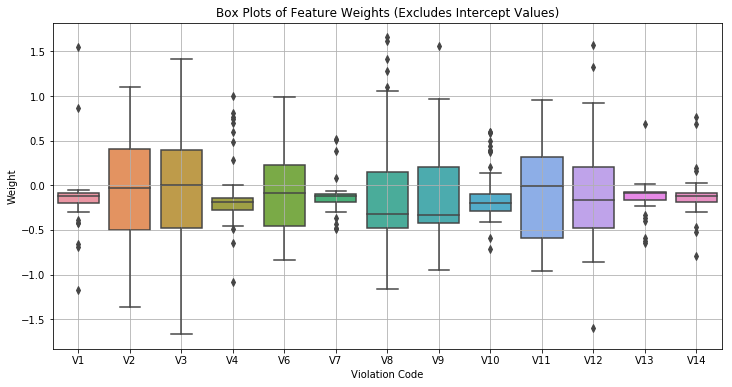

In [29]:
sns.boxplot(x="violation", y="weight", data=wtd)
plt.xlabel("Violation Code")
plt.ylabel("Weight")
plt.title("Box Plots of Feature Weights (Excludes Intercept Values)")
plt.grid()
plt.gcf().set_size_inches(12, 6)
plt.show()

In [30]:
show_top_features(wtd, 3, ascending=False)

weight                feature
violation                                     
V1        25   1.549957       las_islas_marias
          17   0.868882            epic_burger
          45  -0.056452    taco__burrito_house
V10       464  0.597461      sarpinos_pizzeria
          465  0.595174                sbarros
          456  0.581835       papa_johns_pizza
V11       480  0.952418               als_beef
          483  0.891050            au_bon_pain
          501  0.838815                    kfc
V12       547  1.573773            epic_burger
          550  1.328480    halsted_street_deli
          562  0.924053       papa_johns_pizza
V13       597  0.685748          dominos_pizza
          584  0.012186                 z_temp
          628 -0.044225    taco__burrito_house
V14       676  0.769125      sarpinos_pizzeria
          670  0.688615              pizza_hut
          659  0.194680            jimmy_johns
V2        73   1.099734    halsted_street_deli
          58   0.856354               argo_tea
          71   0.805824                freshii
V3        126  1.414794    halsted_street_deli
          116  1.023677             caffe_baci
          151  1.015424    taco__burrito_house
V4        177  1.001436                freshii
          196  0.810006               potbelly
          183  0.767407                    kfc
V6        235  0.992051            jimmy_johns
          237  0.992042       las_islas_marias
          261  0.975483        tokyo_lunch_box
V7        293  0.521588              mcdonalds
          273  0.512627            burger_king
          276  0.384280               chipotle
V8        323  1.657123               argo_tea
          343  1.612492       las_islas_marias
          344  1.410792  lou_malnatis_pizzeria
V9        416  1.558129    taco__burrito_house
          422  0.969994               wingstop
          396  0.825863       las_islas_marias

In [31]:
show_top_features(wtd, 3, ascending=True)

weight             feature
violation                                  
V1        44  -1.168747              subway
          15  -0.689734       dunkin_donuts
          43  -0.663002           starbucks
V10       447 -0.711105         jimmy_johns
          431 -0.587647      baskin_robbins
          430 -0.409455         au_bon_pain
V11       523 -0.956863           taco_bell
          496 -0.926891     giordanos_pizza
          488 -0.870290            chipotle
V12       573 -1.600418           starbucks
          542 -0.862703  corner_bakery_cafe
          560 -0.841609       panda_express
V13       598 -0.643509       dunkin_donuts
          626 -0.626772           starbucks
          627 -0.587638              subway
V14       651 -0.796918       dunkin_donuts
          664 -0.521126           mcdonalds
          673 -0.467573            potbelly
V2        96  -1.369557           starbucks
          104 -1.029721            wingstop
          61  -1.016263         burger_king
V3        149 -1.666384           starbucks
          152 -1.330542           taco_bell
          114 -1.302386         burger_king
V4        174 -1.082083       dunkin_donuts
          202 -0.651885           starbucks
          170 -0.488069            chipotle
V6        255 -0.836691           starbucks
          220 -0.823482         burger_king
          258 -0.723080           taco_bell
V7        309 -0.490401              subway
          302 -0.475001            potbelly
          288 -0.438141         jimmy_johns
V8        362 -1.160732              subway
          342 -0.847966                 kfc
          330 -0.799000  corner_bakery_cafe
V9        414 -0.947664           starbucks
          401 -0.665009       panda_express
          379 -0.659656         burger_king